## Outline
1. Load Libraries
2. Functions
    * 2.1 Intensity and Sleep Plots
    * 2.2 Retrieve Sleep Data
    * 2.3 Retrieve Activity Data
    * 2.4 Prophet Prediction
    * 2.5 Prophet Prediction Plot
    * 2.6 Prophet Component Plot
3. Data Retrieval
    * 3.1 CSV import loop
    * 3.2 Dataframe Retrieval and merge
4. Visualizations
    * 4.1 Activity data timeseries trend
    * 4.2 Activity data Prophet prediction
    * 4.3 Sleep vs. Activity scatter plot and histograms for all data
    * 4.4 Sleep vs. Activity scatter plots by user Id
    * 4.5 Python Panel interactive data exploration tool
5.  Extra Code
    * Extra code can be found in the q2_sleep_impact_full.ipynb notebook under the "More Code" Section.
        - outlier analysis
        - manual activity data retrieval
        - manual sleep data retrieval
        - sleep data pull using user input
        - merge code
        - manual plotting
        - manual plotting using gridspec
        - previous python panel version 


## 1.  Load Libraries

In [197]:
#load libraries
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os as os
import panel as pn
import math

pn.extension()

## 2.  Functions

In [198]:
#2.1 intensity and sleep comparison
def intensity_sleep_plots(data, sleep_level="all",user_id="all",activity_level="all"):
    #variables
    x_tick_fs=10
    y_tick_fs=10
    x_label_fs=12
    y_label_fs=12
    title_fs=14
    max_x=data["sleep_minutes"].max()
    max_y=data["intensity_minutes"].max()
    x_interval=math.ceil(max_x/20)
    y_interval=math.ceil(max_y/20)
    min_x=0-x_interval
    min_y=0-y_interval

    #corelation coefficient
    cor_matrix=data[["intensity_minutes","sleep_minutes"]].corr()
    cor_coef=round(cor_matrix.loc["intensity_minutes","sleep_minutes"],4)

    #level descriptions
    match sleep_level:
        case("all"):
            desc_sleep_level="All Sleep Levels"
        case(1):
            desc_sleep_level="Light Sleep Only"
        case(2):
            desc_sleep_level="Deep Sleep Only"
        case(3):
            desc_sleep_level="REM Sleep Only"

    match user_id:
        case("all"):
            desc_user_id="All Users"
        case _:
            desc_user_id=str(user_id)

    match activity_level:
        case("all"):
            desc_activity_level="All Activity Levels"
        case(1):
            desc_activity_level="Light Activity Only"
        case(2):
            desc_activity_level="Moderate Activity Only"
        case(3):
            desc_activity_level="Vigorous Activity Only"

    #scatter plot
    fig1, ax1 = plt.subplots(figsize=(7,6))
    ax1.scatter(x=data["sleep_minutes"], y=data["intensity_minutes"])
    ax1.set_yticks(ticks=range(min_y,max_y+y_interval,y_interval))
    ax1.tick_params(axis="y", labelsize=y_tick_fs)
    ax1.set_ylim(min_y,max_y+y_interval)
    ax1.set_xticks(ticks=range(min_x,max_x+x_interval,x_interval))
    ax1.set_xlim(min_x,max_x+x_interval)
    ax1.tick_params(axis="x", labelsize=x_tick_fs,rotation=90)
    ax1.set_xlabel("Amount of Sleep (min)",fontweight="bold",fontsize=x_label_fs)
    ax1.set_ylabel("Amount of Activity (min)",fontweight="bold",fontsize=y_label_fs)
    ax1.set_title(f"Amount of Sleep vs. Amount of Activity\n {desc_sleep_level}, {desc_user_id}, {desc_activity_level}",fontweight="bold",fontsize=title_fs)
    ax1.annotate(f"Corr Coef: {cor_coef}",xy=(0.65,0.9),xycoords="axes fraction", color="red",fontsize=12, fontweight="bold")
    plt.close() 

    #plot histogram of sleep
    fig2, ax1 = plt.subplots(figsize=(7,6))
    n, bins, patches=ax1.hist(data["sleep_minutes"],bins=25)
    ax1.set_xlim(min_x,max_x+x_interval)
    ax1.set_xticks(ticks=range(min_x,max_x+x_interval,math.ceil((max_x+x_interval)/25)))
    ax1.set_xlabel("Amount of Sleep Bin",fontweight="bold",fontsize=x_label_fs)
    ax1.tick_params(axis="x", rotation=90,labelsize=x_tick_fs)
    ax1.set_ylim(0,int(n.max())+math.ceil((int(n.max())/20)))
    ax1.set_yticks(ticks=range(0,int(n.max())+math.ceil((int(n.max())/20)),math.ceil(int(n.max())/20)))
    ax1.set_ylabel("Count",fontweight="bold",fontsize=y_label_fs)
    ax1.tick_params(axis="y",labelsize=y_tick_fs)
    ax1.set_title(f"Histogram of Amount of Sleep\n{desc_sleep_level}, {desc_user_id}, {desc_activity_level}", fontweight="bold",fontsize=title_fs)
    plt.close() 

    #plot histogram of activity
    fig3, ax1 = plt.subplots(figsize=(7,6))
    n, bins, patches=ax1.hist(data["intensity_minutes"],bins=25)
    ax1.set_xlim(min_y,min_y+y_interval)
    ax1.set_xticks(ticks=range(min_y,max_y+y_interval,math.ceil((max_y+y_interval)/25)))
    ax1.set_xlabel("Amount of Activity Bin",fontweight="bold",fontsize=x_label_fs)
    ax1.tick_params(axis="x", rotation=90,labelsize=x_tick_fs)
    ax1.set_ylim(0,int(n.max())+math.ceil((int(n.max())/20)))
    ax1.set_yticks(ticks=range(0,int(n.max())+math.ceil((int(n.max())/20)),math.ceil(int(n.max())/20)))
    ax1.set_ylabel("Count",fontweight="bold", fontsize=y_label_fs)
    ax1.tick_params(axis="y",labelsize=y_tick_fs)
    ax1.set_title(f"Histogram of Amount of Activity\n{desc_sleep_level}, {desc_user_id}, {desc_activity_level}", fontweight="bold",fontsize=title_fs)
    plt.close() 

    
    return([fig1,fig2,fig3,desc_sleep_level,desc_user_id,desc_activity_level])

In [199]:
#2.2 get sleep data

def get_sleep_data(sleep_level, user_id):
    #load the dataframe
    df_sleep_minute=dataframes_dict['minuteSleep_merged'].copy()

    #convert date to date time, extract the date
    df_sleep_minute["date"]=pd.to_datetime(df_sleep_minute["date"],format='%m/%d/%Y %I:%M:%S %p')
    df_sleep_minute["date2"]=df_sleep_minute["date"].dt.strftime('%Y-%m-%d')

    #filter to sleep level and user_id
    #convert inputs to int
    match (str(sleep_level).lower(), str(user_id).lower()):
        case("all","all"):
            pass #no filtering taking place
        case(_,"all"):
            sleep_level=int(sleep_level)
            df_sleep_minute=df_sleep_minute[(df_sleep_minute["value"]==sleep_level)]
        case("all",_):
            user_id=int(user_id)
            df_sleep_minute=df_sleep_minute[(df_sleep_minute["Id"]==user_id)]
        case _:
            sleep_level=int(sleep_level)
            user_id=int(user_id)
            df_sleep_minute=df_sleep_minute[(df_sleep_minute["value"]==sleep_level) & (df_sleep_minute["Id"]==user_id)]


    #remove duplicates (some of the 4/12 data is in both files)
    df_sleep_minute=df_sleep_minute.drop_duplicates()

    #find max date because logId spans midnight
    df_max_date_logid=df_sleep_minute.groupby(by=["logId"]).agg(
    max_date=("date2","max")).reset_index()

    #merge in max date with sleep data
    df_sleep_minute=pd.merge(df_sleep_minute,df_max_date_logid,
                             how="left",
                             on="logId")

    #group and aggregate
    df_sleep_day=df_sleep_minute.groupby(by=["Id","logId"]).agg(
        sleep_minutes=("value","count"),
        date=("max_date","max")).reset_index()

    #drop logId column amd reorder
    df_sleep_day=df_sleep_day.drop(columns=["logId"])
    df_sleep_day=df_sleep_day[["Id","date","sleep_minutes"]]

    return ([df_sleep_day,sleep_level,user_id])

In [200]:
#2.3 get intensity data
def get_intensity_data(activity_level,user_id):
    #load the dataframe
    df_intensity_minute=dataframes_dict['minuteIntensitiesNarrow_merged'].copy()

    #convert ActivityMinute to date time and extract the date
    df_intensity_minute["ActivityMinute"]=pd.to_datetime(df_intensity_minute["ActivityMinute"],format='%m/%d/%Y %I:%M:%S %p')
    df_intensity_minute["date"]=df_intensity_minute["ActivityMinute"].dt.strftime('%Y-%m-%d')

    #filter to activity level and user id
    #convert inputs to int
    match (str(activity_level).lower(), str(user_id).lower()):
        case("all","all"):
            pass #no filtering taking place
        case(_,"all"):
            activity_level=int(activity_level)
            df_intensity_minute=df_intensity_minute[(df_intensity_minute["Intensity"]==activity_level)]
        case("all",_):
            user_id=int(user_id)
            df_intensity_minute=df_intensity_minute[(df_intensity_minute["Id"]==user_id)]
        case _:
            activity_level=int(activity_level)
            user_id=int(user_id)
            df_intensity_minute=df_intensity_minute[(df_intensity_minute["Intensity"]==activity_level) & (df_intensity_minute["Id"]==user_id)]
    
    #remove duplicates (some of the 4/12 data is in both files)
    df_intensity_minute=df_intensity_minute.drop_duplicates()

    #Remove rows where Intensity is 0 (0 is resting)
    df_intensity_day=df_intensity_minute[df_intensity_minute["Intensity"] !=0]

    #drop the ActivityMinute column and group by Id and date
    df_intensity_day=df_intensity_day.drop(columns=["ActivityMinute"])
    df_intensity_day=df_intensity_day.groupby(by=["Id","date"]).agg   (intensity_minutes=("Intensity","count")).reset_index()

    return([df_intensity_day,activity_level,user_id])


In [201]:
#2.4 prediction function
def make_prediction(period):
    future=model.make_future_dataframe(periods=int(period),freq="D")
    forecast=model.predict(future)
    return(forecast)

In [202]:
#2.5 function for Prophet Prediction Plot
def prediction_plot(forecasted_data):
    #create the Prophet plot
    fig1=model.plot(forecasted_data, figsize=(10,6))
    ax1=fig1.gca() #get current axis from the Prophet plot 
    ax1.set_title("User Activity Tracked with Fitbit")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Activity Minutes")
    ax1.grid(True)
    fig1.tight_layout()
    plt.close() #so don't show the plot while executing function, only when returned
    return(fig1)

In [203]:
#2.6 function for Prophet Component Plot
def component_plot(forecasted_data):
    #Create plot
    fig1=model.plot_components(forecasted_data,figsize=(10,6))
    ax1=fig1.gca()
    ax1.set_title("Prediction Components")
    ax1.set_xlabel("Date")
    ax1.grid=True
    plt.close()
    return(fig1)

## 3. Data Retrieval

In [204]:
#3.1 loop to read in data from CSVs and make dataframes

march_path="./data/march_april/"
april_path="./data/april_may/"

march_file_list=[file for file in os.listdir(march_path) if file.endswith('.csv')]

april_file_list=[file for file in os.listdir(april_path) if file.endswith('.csv')]

#function to check if march and april lists are identical
def compare_lists(list1,list2):
    if len(list1) != len(list2):
        return False
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            return False
    return True


#loop to read files
dataframes_dict={}
if compare_lists(march_file_list,april_file_list)==True:
    for i in range(len(march_file_list)):
        dataframes_dict[march_file_list[i][:len(march_file_list[i])-4]]=pd.concat([pd.read_csv(march_path+march_file_list[i]),pd.read_csv(april_path+april_file_list[i])])
else: 
    print(f"Check to see if the same number of files are in each directory and if the names are the same.  compare= {compare_lists(march_file_list,april_file_list)}")                                                                                                


In [205]:
#3.2 dataframe retrieval and merge
#get intensity data
df_intensity_day=get_intensity_data("all","all")[0]

#get sleep data
df_sleep_day=get_sleep_data("all","all")[0]

#merge
#merge intensity and sleep data
df_intensity_sleep_day=pd.merge(df_intensity_day,df_sleep_day,
                                how="inner",
                                on=["Id","date"]
                                )

df_intensity_sleep_day.info()
display(df_intensity_sleep_day.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 1006 non-null   int64 
 1   date               1006 non-null   object
 2   intensity_minutes  1006 non-null   int64 
 3   sleep_minutes      1006 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.6+ KB


,Id,date,intensity_minutes,sleep_minutes
0,1503960366,2016-03-13,334,426
1,1503960366,2016-03-14,298,386
2,1503960366,2016-03-15,403,335
3,1503960366,2016-03-16,318,303
4,1503960366,2016-03-16,318,63


## 4.  Visualizations

<Axes: xlabel='date'>

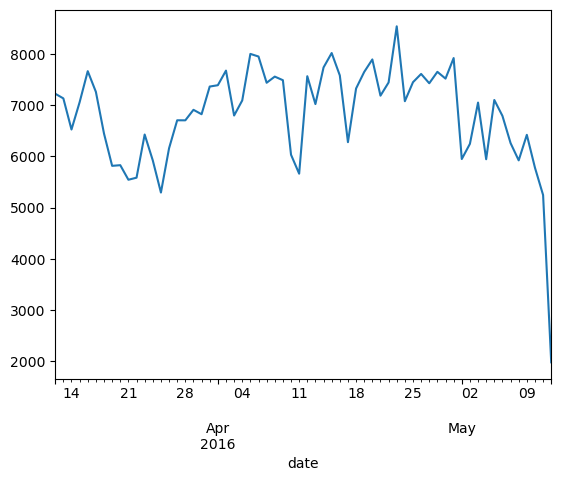

In [206]:
#4.1 activity time series
#data wrangling
df_activity_ts=df_intensity_day
#drop Id column
df_activity_ts=df_activity_ts.drop(columns="Id")
#set date to datetime
df_activity_ts["date"]=pd.to_datetime(df_activity_ts["date"])
#make date the index
df_activity_ts.set_index("date",inplace=True)
#sum up by date
df_activity_ts=df_activity_ts.groupby(df_activity_ts.index).sum()

df_activity_ts


#plot the trend
df_activity_ts["intensity_minutes"].plot()



14:17:06 - cmdstanpy - INFO - Chain [1] start processing
14:17:06 - cmdstanpy - INFO - Chain [1] done processing


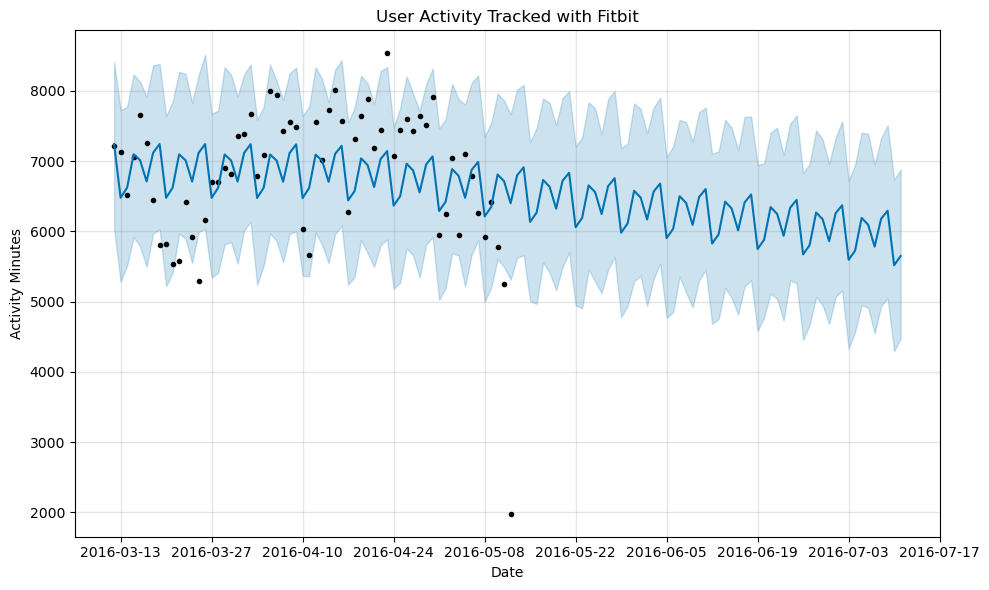

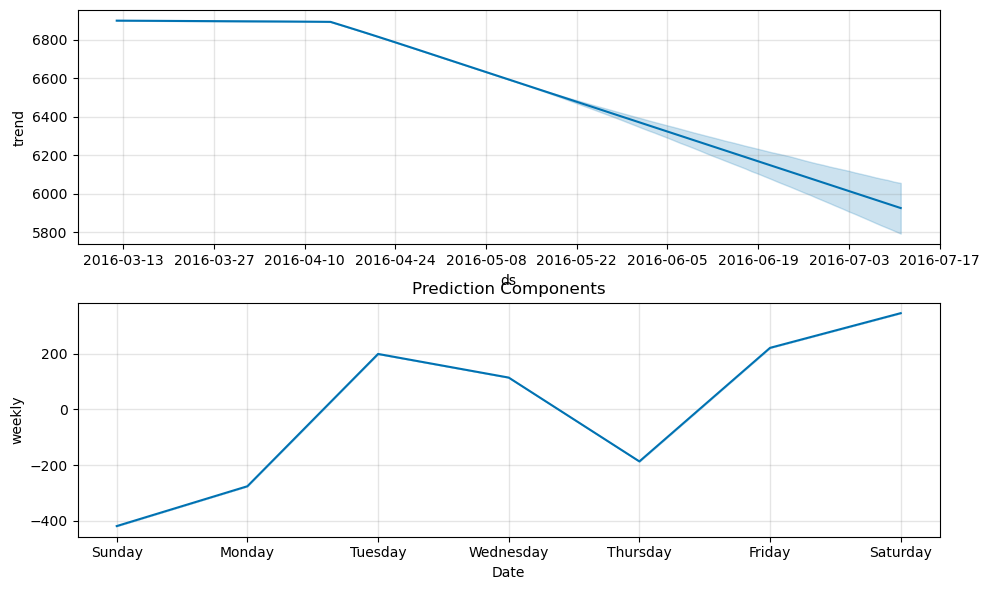

In [207]:
#4.2 activity Prophet analysis
df_activity_p=df_activity_ts.copy()
df_activity_p=df_activity_p.reset_index()
#rename columns for prophet
df_activity_p=df_activity_p.rename(columns={"date":"ds","intensity_minutes":"y"})
#sort by ascending ds
df_activity_p=df_activity_p.sort_values(by=["ds"], ascending=True)
#call Prophet and store
model=Prophet()
#fit the model
model.fit(df_activity_p)
#make future dataframe and forecast
forecast_trends=make_prediction(60)
#plot the prediction
display(prediction_plot(forecast_trends))
display(component_plot(forecast_trends))




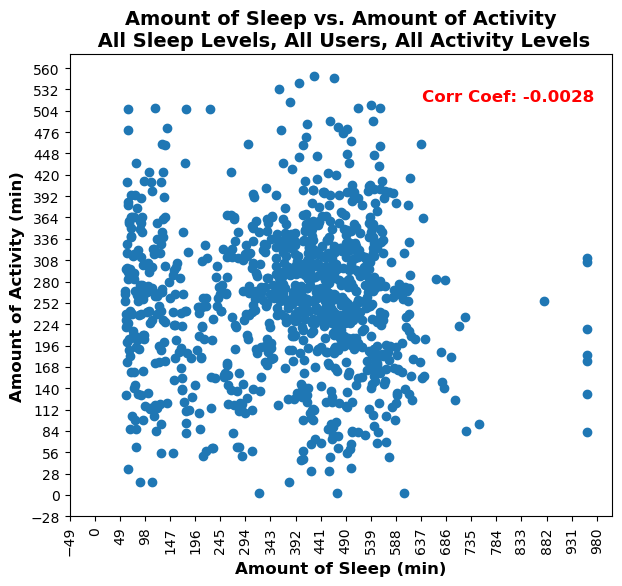

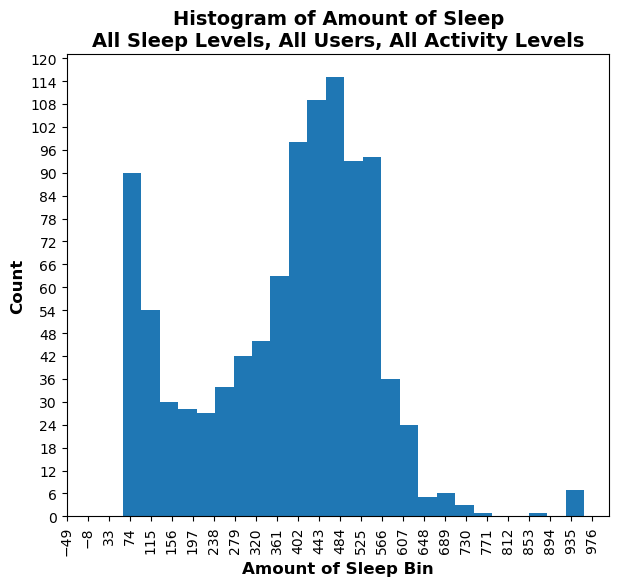

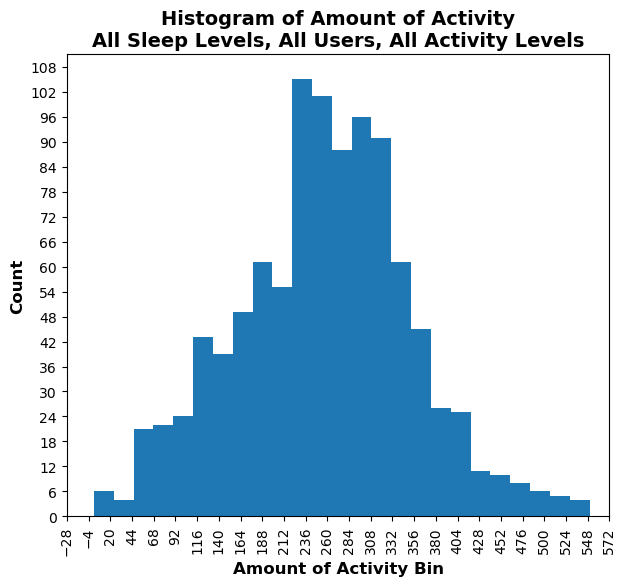

In [208]:
#4.3 scatter plot and histograms for sleep vs. activity.  all sleep levels, user ids, and activity levels.

intensity_sleep_figures=intensity_sleep_plots(df_intensity_sleep_day,"all","all","all")


display(intensity_sleep_figures[0])
display(intensity_sleep_figures[1])
display(intensity_sleep_figures[2])

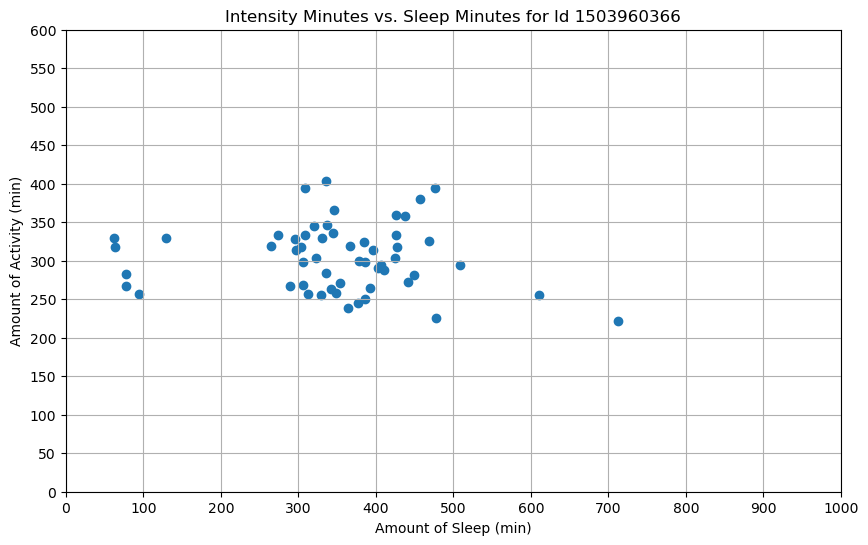

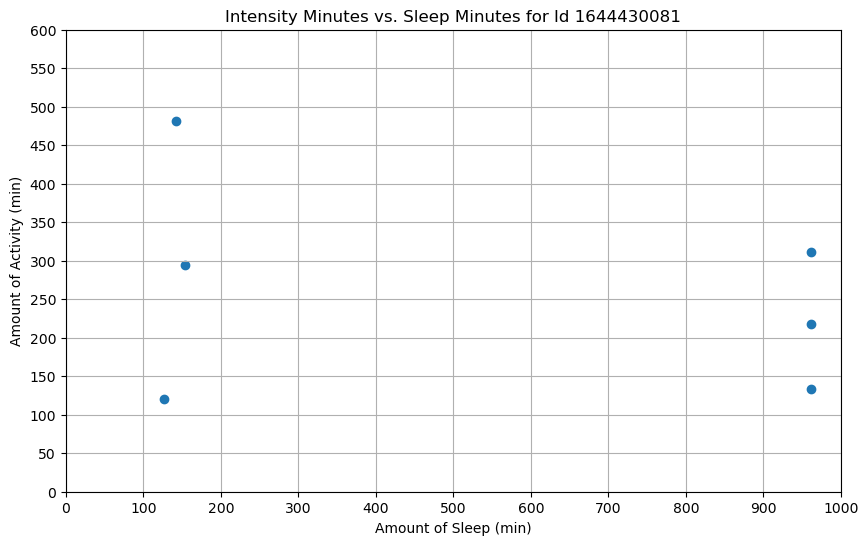

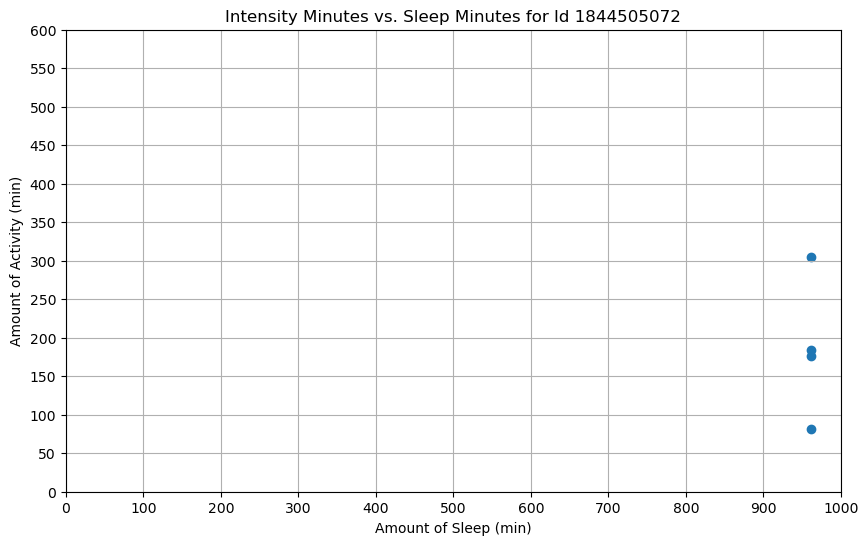

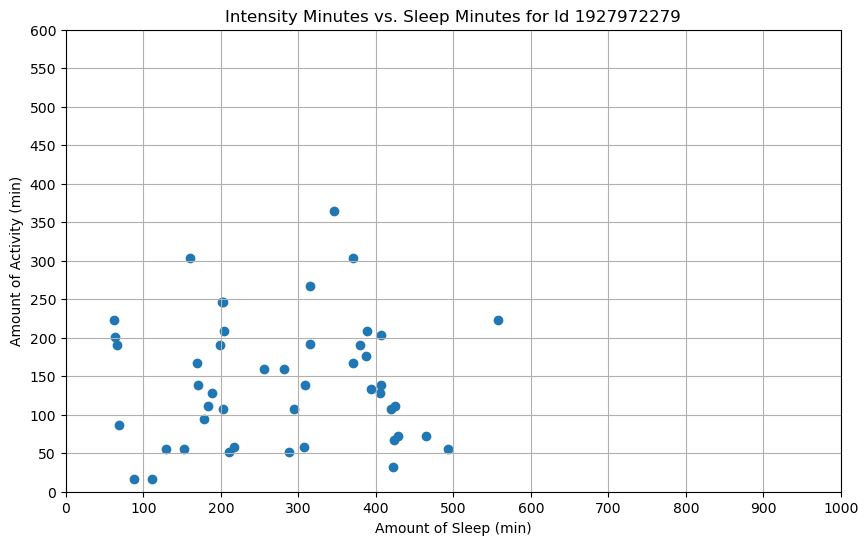

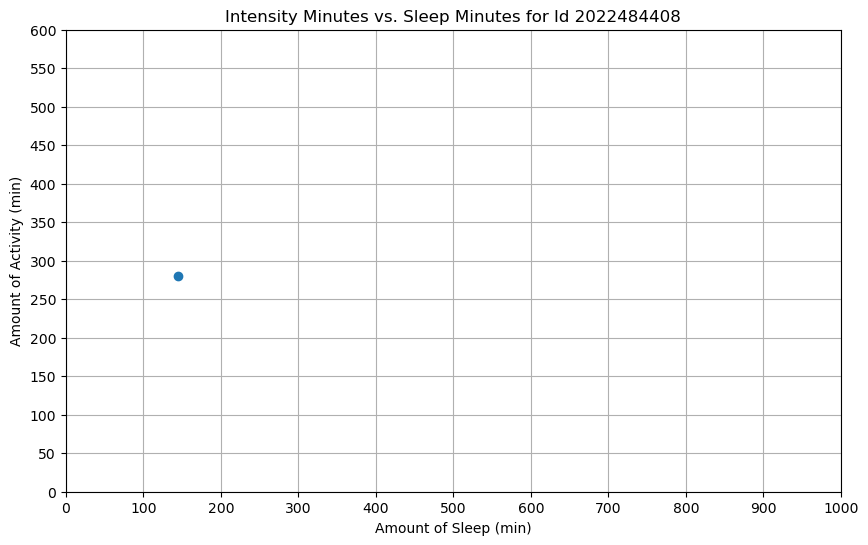

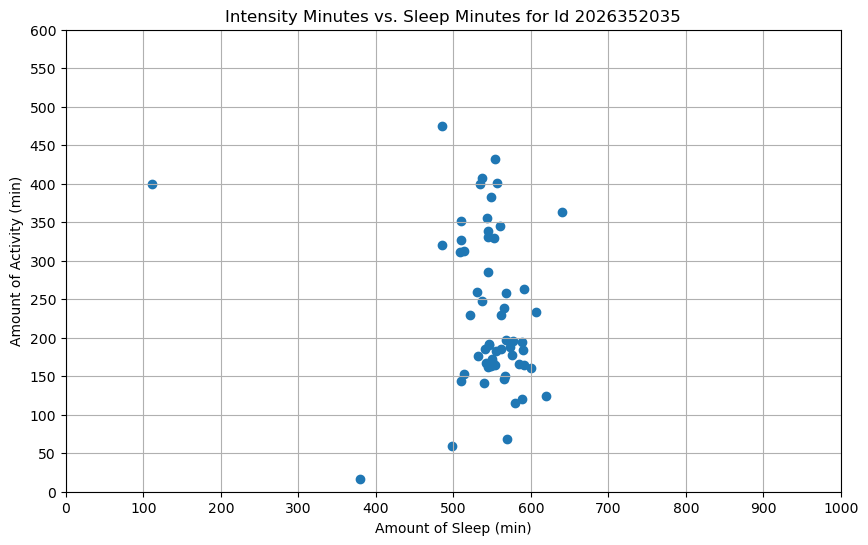

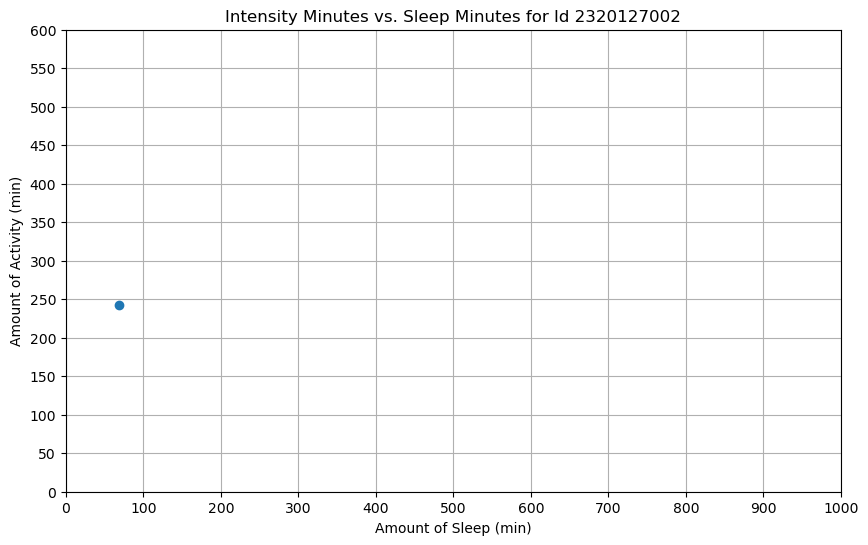

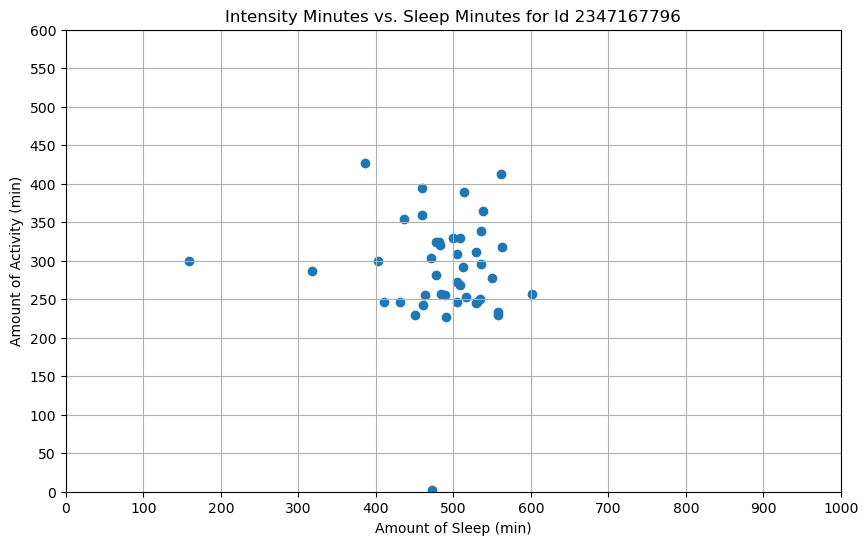

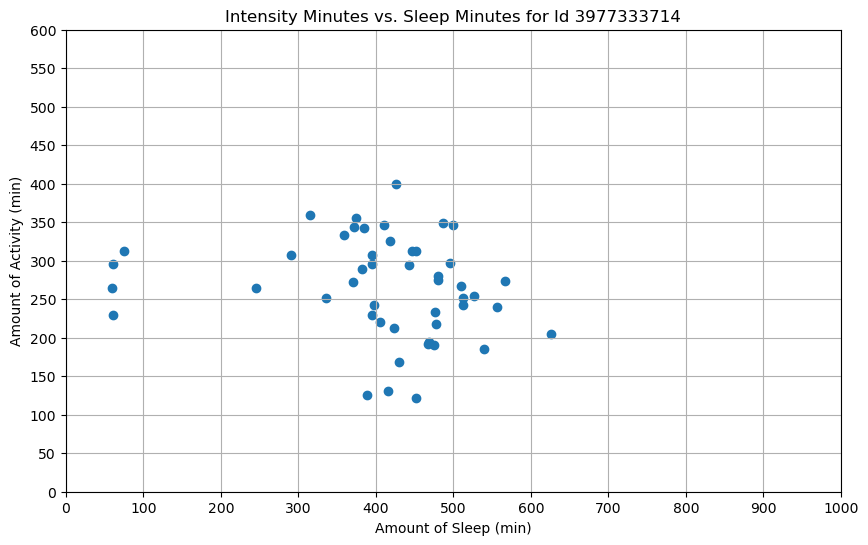

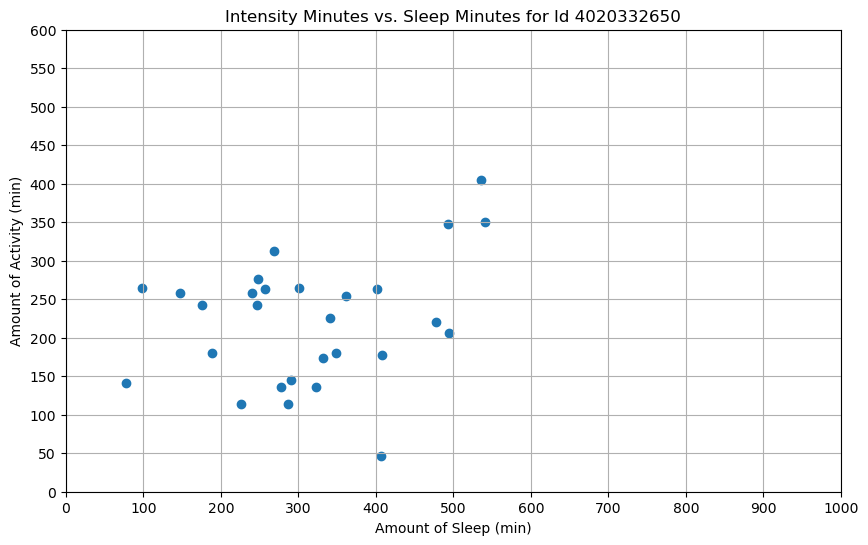

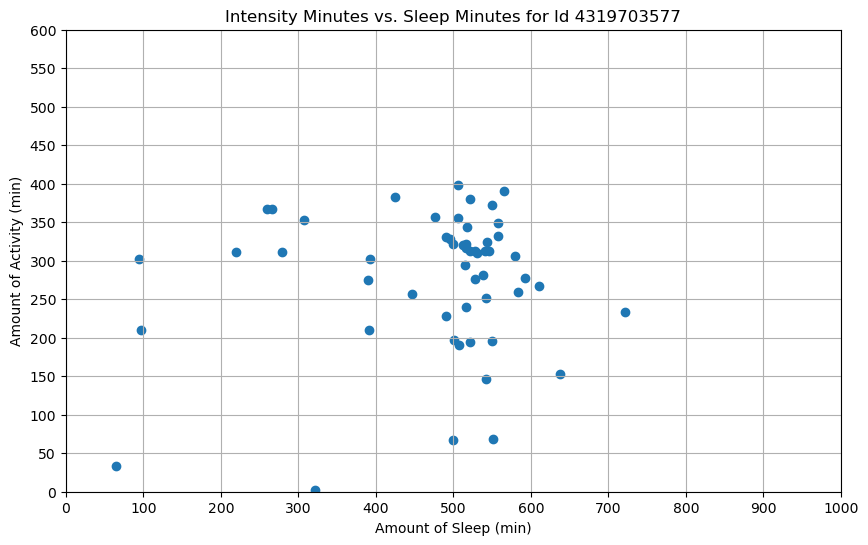

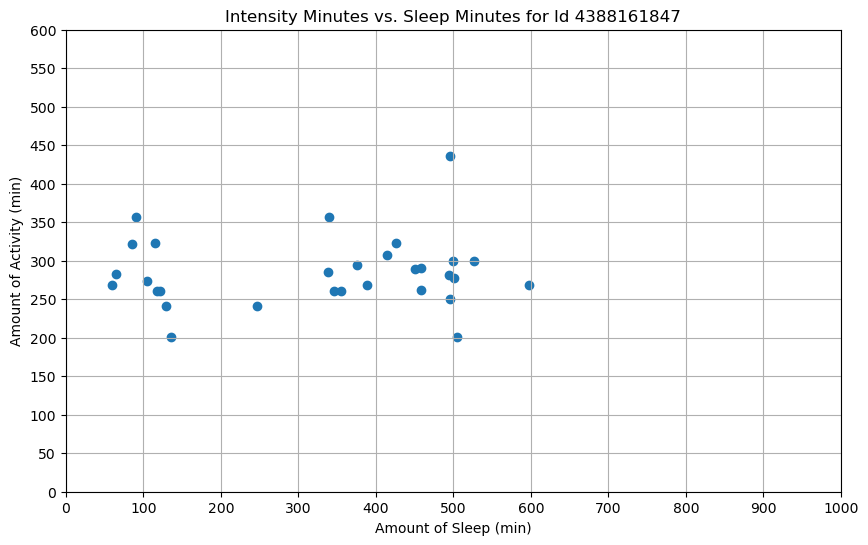

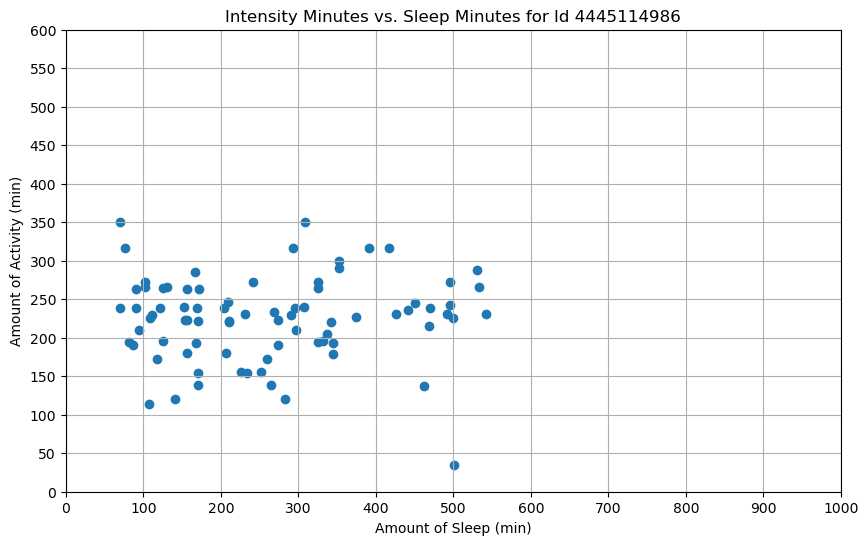

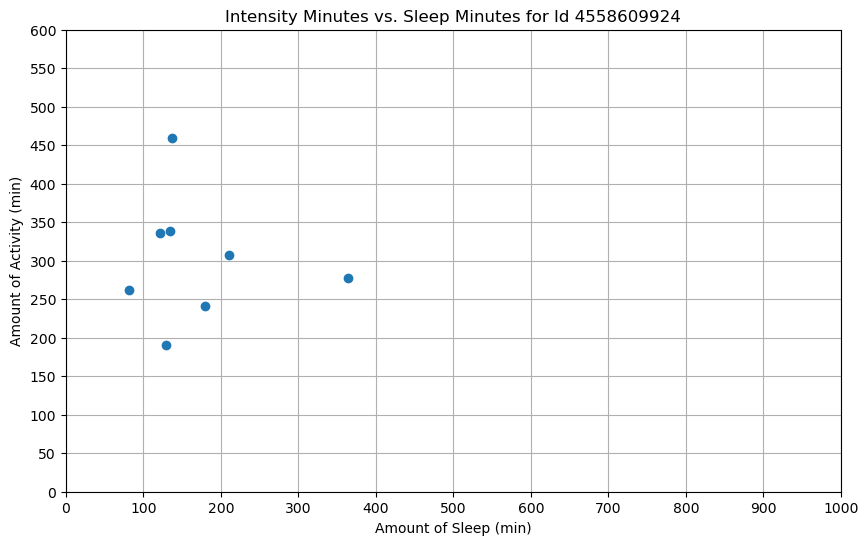

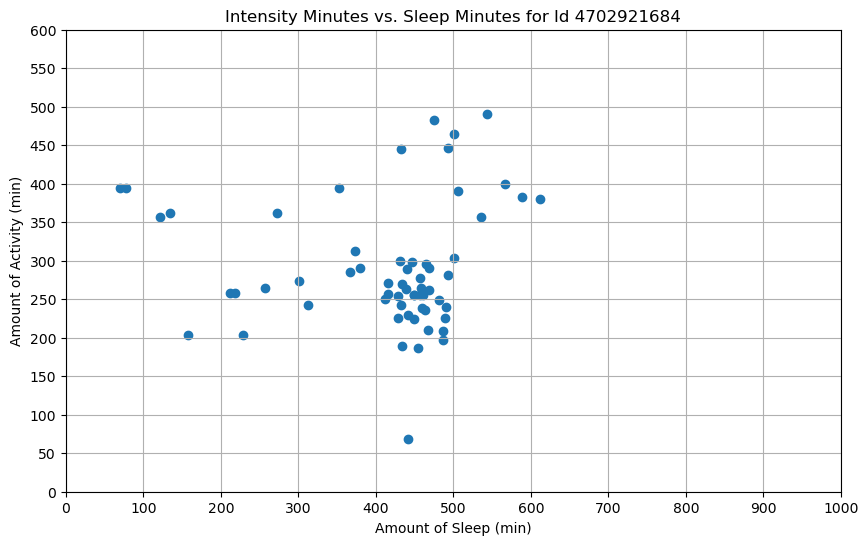

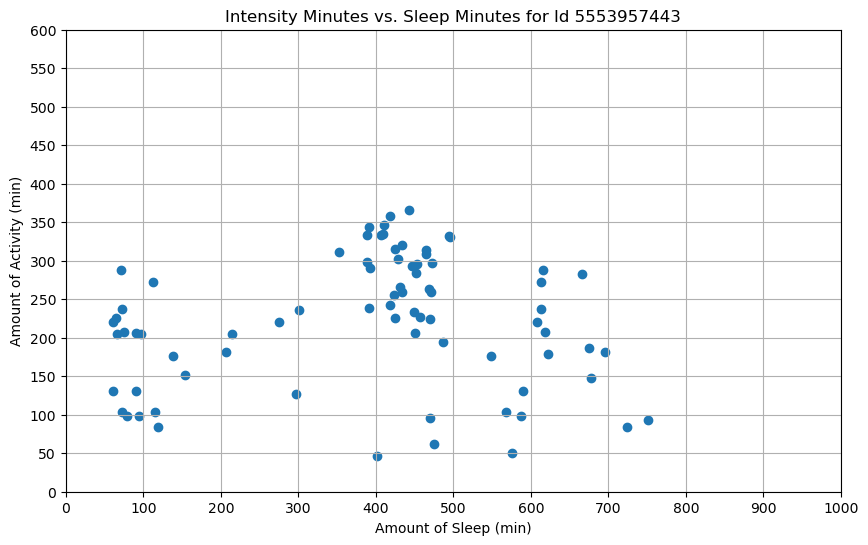

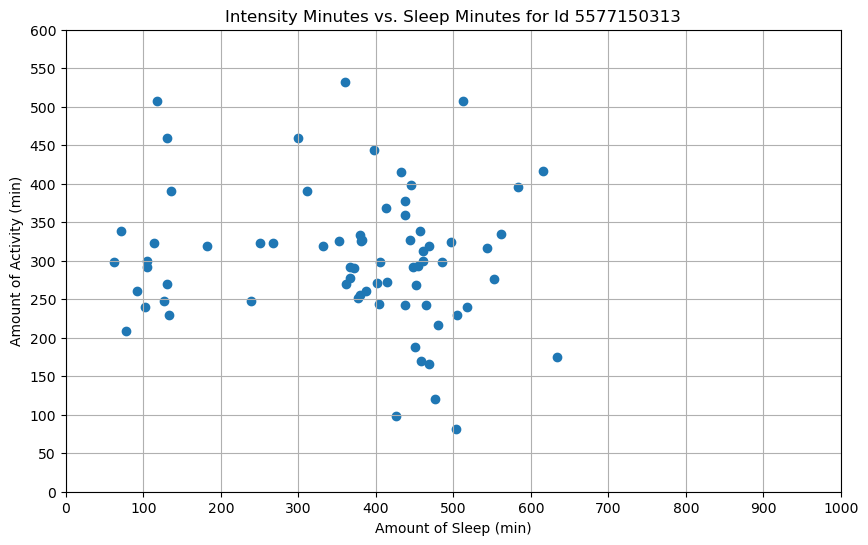

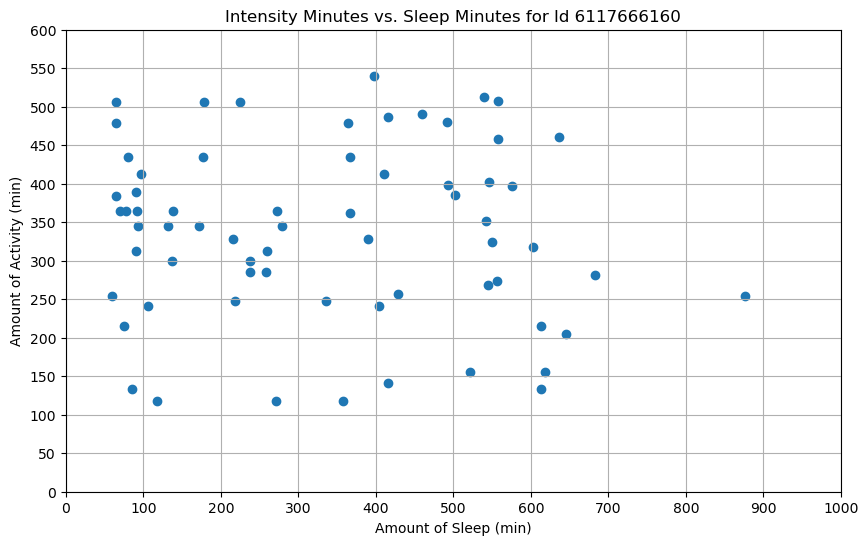

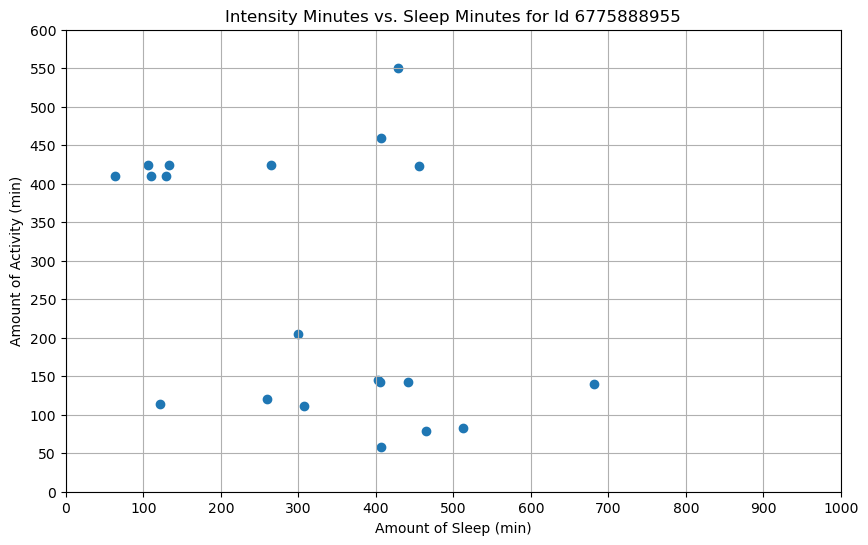

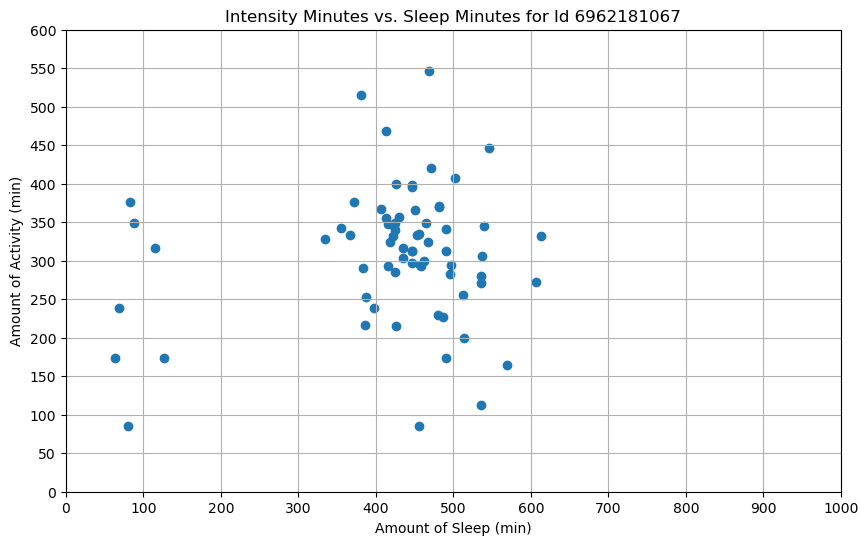

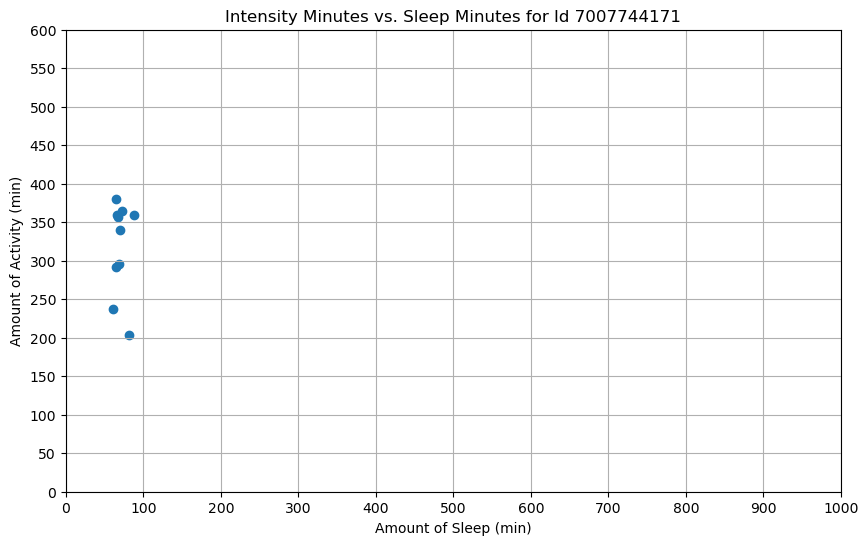

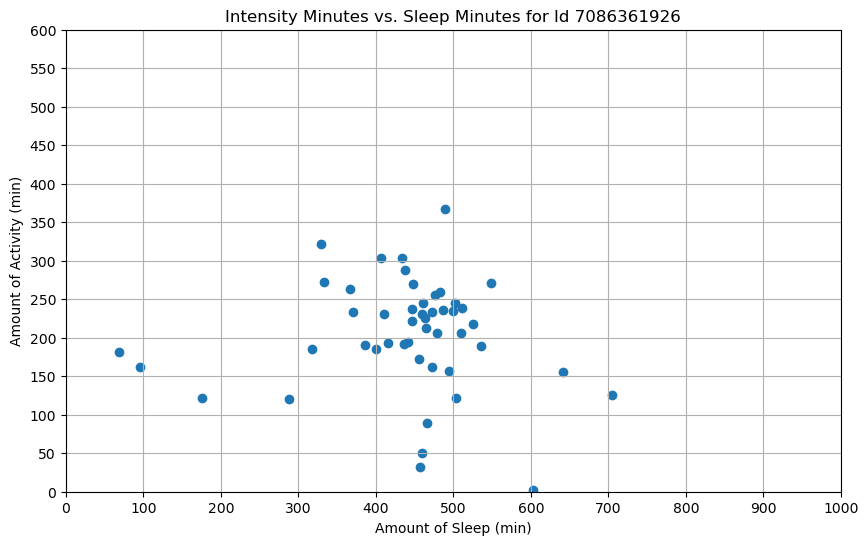

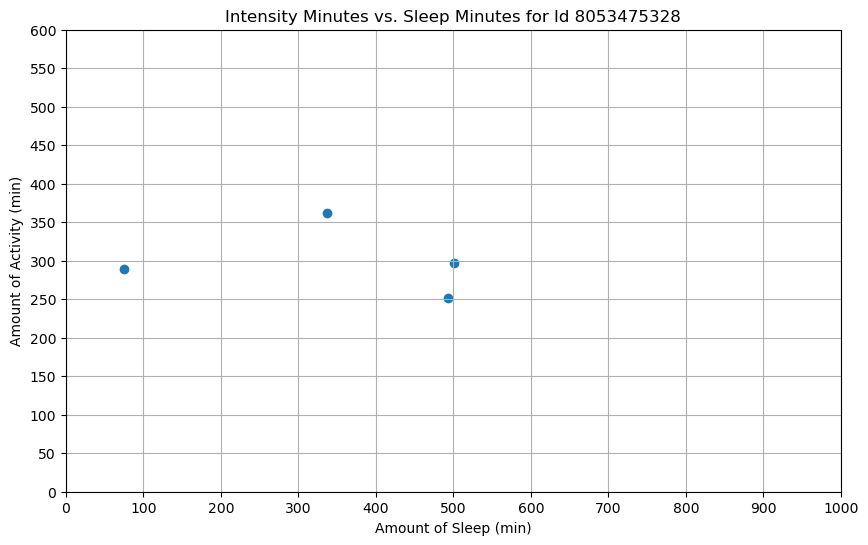

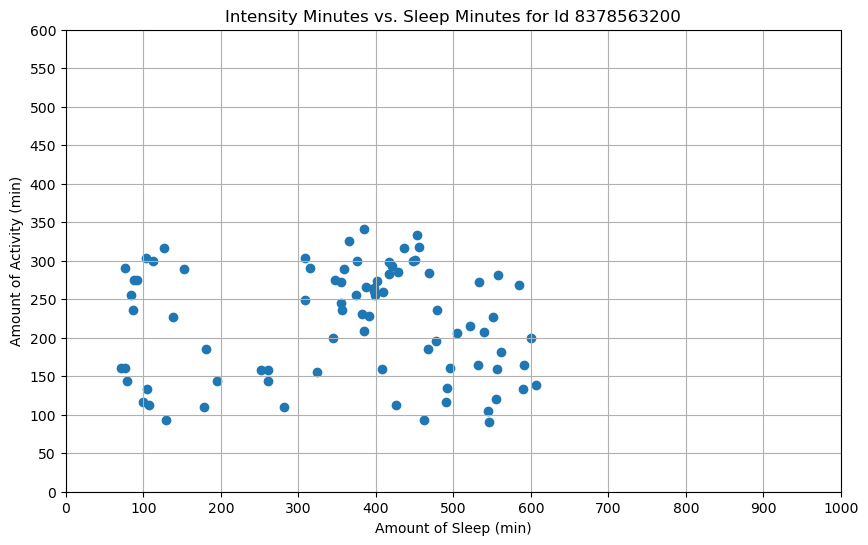

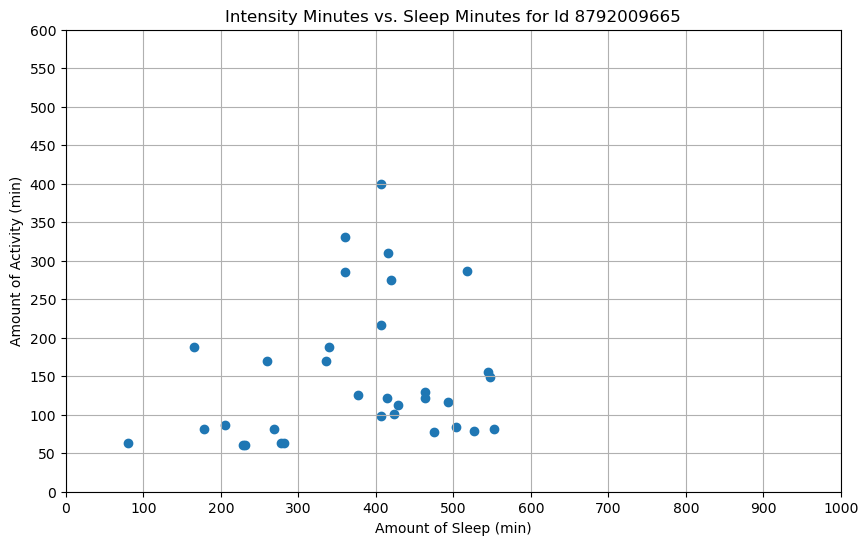

In [209]:
#scatter plots for activity vs. sleep for plot individual plots
#plot
unique_ids=df_intensity_sleep_day["Id"].unique()

for id in unique_ids:
    plt.figure(figsize=(10,6))
    subset=df_intensity_sleep_day[df_intensity_sleep_day["Id"]==id]
    plt.scatter(subset["sleep_minutes"], subset["intensity_minutes"])
    plt.xlim(0,1000)
    plt.xticks(range(0,1001,100))
    plt.ylim(0,600)
    plt.yticks(range(0,601,50))
    plt.xlabel("Amount of Sleep (min)")
    plt.ylabel("Amount of Activity (min)")
    plt.title(f'Intensity Minutes vs. Sleep Minutes for Id {id}')
    plt.grid(True)
    plt.show()

In [210]:
#4.5 python panel for interactive data exploration and summary visualization
#sleep_level_widget
sleep_level_widget=pn.widgets.Select(name="Choose Sleep Level",options=["All Levels","Light Sleep","Deep Sleep","REM Sleep"], value="All Levels",width=306)

#activity_level_widget
activity_level_widget=pn.widgets.Select(name="Choose Activity Level",options=["All Levels","Light Activity","Moderate Activity","Vigorous Activity"], value="All Levels",width=306)

#user_Id_widget
unique_ids=df_intensity_sleep_day["Id"].unique().tolist()
unique_ids=["All Users"] + unique_ids
user_id_widget=pn.widgets.Select(name="Choose User Id",options=unique_ids,value="All Users",width=306)

#day_widget
days_widget=pn.widgets.IntSlider(
    name="Select the number of days to predict (1-365)", 
    start=1, 
    end=365, 
    step=1, 
    value=10)

#define initial data
#get intensity data
panel_intensity_day=get_intensity_data("all","all")[0]

#get sleep data
panel_sleep_day=get_sleep_data("all","all")[0]

#merge intensity and sleep data
panel_data=pd.merge(panel_intensity_day,panel_sleep_day,
                                how="inner",
                                on=["Id","date"]
                                )

#initial plot Sleep vs. Activity Tab
intensity_sleep_figures=intensity_sleep_plots(panel_data,"all","all","all")
scatter=pn.pane.Matplotlib(intensity_sleep_figures[0],dpi=90)
sleep_hist=pn.pane.Matplotlib(intensity_sleep_figures[1],dpi=44)
activity_hist=pn.pane.Matplotlib(intensity_sleep_figures[2],dpi=44)

#initial plot Activity Timeseries Tab
prediction=pn.pane.Matplotlib(prediction_plot(forecast_trends),dpi=80)
components=pn.pane.Matplotlib(component_plot(forecast_trends),dpi=80)

#dashboard
#Sleep vs. Activity Tab
widget_row=pn.Row(sleep_level_widget,activity_level_widget,user_id_widget)
plot_row=pn.Row(scatter,pn.Column(sleep_hist,activity_hist),sizing_mode="stretch_both")

#Activity Timeseries Tab
#fig1=model.plot(forecast_trends, figsize=(10,6));
prediction_row=pn.Row(prediction)
component_row=pn.Row(components)

#all together
dashboard=pn.Tabs(
    ("Sleep vs. Activity",pn.Column(widget_row,plot_row)),
    ("Activity Timeseries",pn.Column(days_widget,prediction_row,component_row))
)

#panel update functions
#sleep vs. activity tab
def update_tab1(event):
    match sleep_level_widget.value:
        case("Light Sleep"):
            sleep_level=1
        case("Deep Sleep"):
            sleep_level=2
        case("REM Sleep"):
            sleep_level=3
        case("All Levels"):
            sleep_level="all"

    match user_id_widget.value:
        case("All Users"):
            user_id="all"
        case _:
            user_id=float(user_id_widget.value)

    match activity_level_widget.value:
        case("All Levels"):
            activity_level="all"
        case("Light Activity"):
            activity_level=1
        case("Moderate Activity"):
            activity_level=2
        case("Vigorous Activity"):
            activity_level=3

    #updated dataframes and widget levels
    updated_sleep_data=get_sleep_data(sleep_level,user_id)
    updated_activity_data=get_intensity_data(activity_level,user_id)
    updated_sleep_df=updated_sleep_data[0]
    updated_sleep_level=updated_sleep_data[1]
    updated_user_id=updated_sleep_data[2]
    updated_activity_df=updated_activity_data[0]
    updated_activity_level=updated_activity_data[1]
    
    #merge intensity and sleep data
    df_updated_data=pd.merge(updated_activity_df,updated_sleep_df,
                                how="inner",
                                on=["Id","date"]
                                )

    #updated plots
    updated_figures = intensity_sleep_plots(df_updated_data, updated_sleep_level, updated_user_id,updated_activity_level)

    scatter.object = updated_figures[0]
    sleep_hist.object = updated_figures[1]
    activity_hist.object = updated_figures[2]

#update for activity timeseries tab
def update_tab2(event):
    prediction.object=prediction_plot(
        make_prediction(days_widget.value))
    components.object=component_plot(
        make_prediction(days_widget.value))
    


#watch for changes in widgets
sleep_level_widget.param.watch(update_tab1, 'value')
user_id_widget.param.watch(update_tab1,"value")
activity_level_widget.param.watch(update_tab1,"value")
days_widget.param.watch(update_tab2,"value")


#run
dashboard



BokehModel(combine_events=True, render_bundle={'docs_json': {'9d618ecf-be85-4f29-8067-12568ebb4bc9': {'version…